In [1]:
# 1) Import Libraries

# Data manipulation
import pandas as pd
import numpy as np

# Machine Learning - Preprocessing 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Machine Learning - Model selection and validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Machine Learning - Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Machine Learning - Metrics
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report

# Machine Learning - Model Interpretation
from sklearn.inspection import PartialDependenceDisplay
import shap
import scipy.sparse

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Model Saving and Loading
import pickle

In [2]:
# 2) Load and Preprocess the Data

# Load the dataset
data = pd.read_csv('OnlineShopping_Dataset.csv')

# Drop unnecessary column
data.drop(columns=['Unnamed: 0'], inplace=True)

# Define numerical, categorical, date/time, and identifier features
numerical_features = ['Tenure_Months', 'Quantity', 'Avg_Price', 'Delivery_Charges', 'GST', 'Offline_Spend', 'Online_Spend', 'Discount_pct']
categorical_features = ['Gender', 'Location', 'Product_Category', 'Coupon_Status', 'Month']

# Create a pipeline for numerical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Create a pipeline for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformations into a single ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Convert 'Transaction_Date' to datetime
data['Transaction_Date'] = pd.to_datetime(data['Transaction_Date'])

# Sort data for comparison
data.sort_values(by=['CustomerID', 'Transaction_Date'], inplace=True)

# Define churn based on the latest transaction date threshold
threshold_date = pd.Timestamp('2019-05-22')  
data['Inactive_Churn'] = (data.groupby('CustomerID')['Transaction_Date'].transform('max') < threshold_date).astype(int)

# Calculate the percent change in online spending by customer
data['Spend_Change'] = data.groupby('CustomerID')['Online_Spend'].pct_change()

# Define churn based on a significant drop in online spending
data['Spend_Churn'] = (data['Spend_Change'] < -0.50).astype(int)

# Combine both churn indicators: 1 if either condition is met
data['Churn'] = (data['Inactive_Churn'] | data['Spend_Churn']).astype(int)

In [3]:
# 3) Data Splitting 
# Define features (X) and target (y)
X = data.drop(['Churn', 'CustomerID', 'Transaction_ID', 'Transaction_Date', 'Date', 'Product_SKU', 'Product_Description', 'Coupon_Code'], axis=1)
y = data['Churn']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply the preprocessor to the training and testing data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [4]:
print(X_train.columns)

Index(['Gender', 'Location', 'Tenure_Months', 'Product_Category', 'Quantity',
       'Avg_Price', 'Delivery_Charges', 'Coupon_Status', 'GST',
       'Offline_Spend', 'Online_Spend', 'Month', 'Discount_pct',
       'Inactive_Churn', 'Spend_Change', 'Spend_Churn'],
      dtype='object')


In [5]:
# 4) Model Selection and Training

# Initialize the models
logistic_model = LogisticRegression(random_state=42, max_iter=1000)
random_forest_model = RandomForestClassifier(random_state=42, n_estimators=100)

# Train Logistic Regression
logistic_model.fit(X_train_preprocessed, y_train)
# Predict on test set
logistic_pred = logistic_model.predict(X_test_preprocessed)

# Train Random Forest
random_forest_model.fit(X_train_preprocessed, y_train)
# Predict on test set
forest_pred = random_forest_model.predict(X_test_preprocessed)

In [6]:
# 5) Model Evaluation

# Evaluate Logistic Regression
logistic_accuracy = accuracy_score(y_test, logistic_pred)
logistic_roc_auc = roc_auc_score(y_test, logistic_pred)

# Evaluate Random Forest
forest_accuracy = accuracy_score(y_test, forest_pred)
forest_roc_auc = roc_auc_score(y_test, forest_pred)

# Evaluation metrics
print("Logistic Regression Accuracy:", logistic_accuracy)
print("Logistic Regression ROC-AUC:", logistic_roc_auc)
print("Random Forest Accuracy:", forest_accuracy)
print("Random Forest ROC-AUC:", forest_roc_auc)

# Evaluation metrics for Logistic Regression - precision, recall, f1 score
logistic_precision = precision_score(y_test, logistic_pred)
logistic_recall = recall_score(y_test, logistic_pred)
logistic_f1 = f1_score(y_test, logistic_pred)

# Evaluation metrics for Random Forest - precision, recall, f1 score
forest_precision = precision_score(y_test, forest_pred)
forest_recall = recall_score(y_test, forest_pred)
forest_f1 = f1_score(y_test, forest_pred)

print("\nLogistic Regression Precision:", logistic_precision)
print("Logistic Regression Recall:", logistic_recall)
print("Logistic Regression F1 Score:", logistic_f1)
print("Random Forest Precision:", forest_precision)
print("Random Forest Recall:", forest_recall)
print("Random Forest F1 Score:", forest_f1)

Logistic Regression Accuracy: 0.8513832499291851
Logistic Regression ROC-AUC: 0.644738076454682
Random Forest Accuracy: 0.9830988575205363
Random Forest ROC-AUC: 0.9588019036832682

Logistic Regression Precision: 0.5673828125
Logistic Regression Recall: 0.33936915887850466
Logistic Regression F1 Score: 0.42470760233918126
Random Forest Precision: 0.9711124769514444
Random Forest Recall: 0.9228971962616822
Random Forest F1 Score: 0.9463911350703804


In [7]:
# 6) Model Tuning 

# Setting up parameter grid for Logistic Regression
logistic_params = {
    'C': [0.01, 0.1, 1, 10, 100],  
    'solver': ['liblinear', 'saga'], 
    'max_iter': [300, 500, 1000],
    'tol': [1e-4, 1e-3]  
}

# Setting up GridSearchCV for Logistic Regression
logistic_grid = GridSearchCV(estimator=LogisticRegression(random_state=42), 
                             param_grid=logistic_params, 
                             cv=5,  
                             scoring='accuracy',  
                             verbose=1)

# Fit grid search to the data
logistic_grid.fit(X_train_preprocessed, y_train)

# Best parameters and best score
print("Best parameters for Logistic Regression:", logistic_grid.best_params_)
print("Best score for Logistic Regression:", logistic_grid.best_score_)

# Predict using the best estimator from GridSearchCV
best_logistic_pred = logistic_grid.best_estimator_.predict(X_test_preprocessed)

# Re-evaluate the tuned models
best_logistic_accuracy = accuracy_score(y_test, best_logistic_pred)
print("Tuned Logistic Regression Accuracy:", best_logistic_accuracy)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

Best parameters for Logistic Regression: {'C': 1, 'max_iter': 300, 'solver': 'saga', 'tol': 0.001}
Best score for Logistic Regression: 0.851218052856226
Tuned Logistic Regression Accuracy: 0.8509111509772448


In [8]:
# Setting up parameter grid for Random Forest
forest_params = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10]  # Minimum number of samples required to split an internal node
}

# Setting up GridSearchCV for Random Forest
forest_grid = GridSearchCV(estimator=RandomForestClassifier(random_state=42), 
                           param_grid=forest_params, 
                           cv=5, 
                           scoring='accuracy', 
                           verbose=1)

# Fit grid search to the data
forest_grid.fit(X_train_preprocessed, y_train)

tuned_random_forest_model = forest_grid.best_estimator_

# Best parameters and best score
print("Best parameters for Random Forest:", forest_grid.best_params_)
print("Best score for Random Forest:", forest_grid.best_score_)

# Predict using the best estimator from GridSearchCV
best_forest_pred = forest_grid.best_estimator_.predict(X_test_preprocessed)

# Re-evaluate the tuned models
best_forest_accuracy = accuracy_score(y_test, best_forest_pred)
print("Tuned Random Forest Accuracy:", best_forest_accuracy)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters for Random Forest: {'max_depth': 30, 'min_samples_split': 5, 'n_estimators': 200}
Best score for Random Forest: 0.9818006193533491
Tuned Random Forest Accuracy: 0.9830988575205363


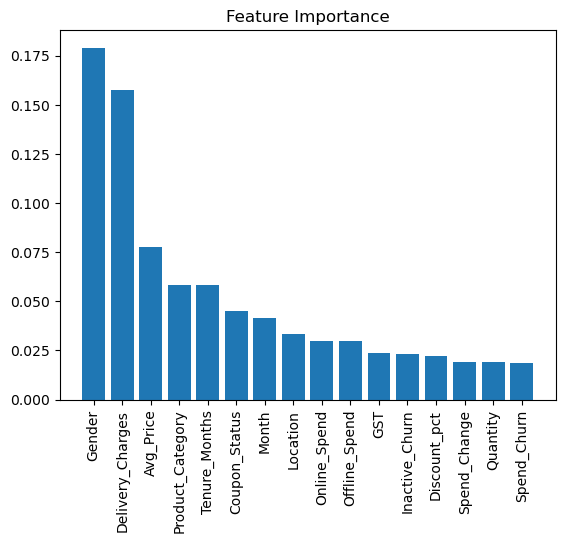

In [9]:
# 7) Model Interpretation

# 7.1 Feature Importance from Random Forest

# Get feature importances from Random Forest
importances = tuned_random_forest_model.feature_importances_
feature_names = X_train.columns.tolist()

# Sort feature importances in descending order and create labels
indices = np.argsort(importances)[::-1]
#names = [feature_names[i] for i in indices]
names = [feature_names[i] for i in indices if i < len(feature_names)]

plt.figure()
plt.title("Feature Importance")
plt.bar(range(len(names)), importances[indices][:len(names)])  # Limit importances to number of names
plt.xticks(range(len(names)), names, rotation=90)
plt.show()

In [10]:
feature_names = preprocessor.get_feature_names_out()
print(feature_names)

['num__Tenure_Months' 'num__Quantity' 'num__Avg_Price'
 'num__Delivery_Charges' 'num__GST' 'num__Offline_Spend'
 'num__Online_Spend' 'num__Discount_pct' 'cat__Gender_F' 'cat__Gender_M'
 'cat__Location_California' 'cat__Location_Chicago'
 'cat__Location_New Jersey' 'cat__Location_New York'
 'cat__Location_Washington DC' 'cat__Product_Category_Accessories'
 'cat__Product_Category_Android' 'cat__Product_Category_Apparel'
 'cat__Product_Category_Backpacks' 'cat__Product_Category_Bags'
 'cat__Product_Category_Bottles' 'cat__Product_Category_Drinkware'
 'cat__Product_Category_Fun' 'cat__Product_Category_Gift Cards'
 'cat__Product_Category_Google' 'cat__Product_Category_Headgear'
 'cat__Product_Category_Housewares' 'cat__Product_Category_Lifestyle'
 'cat__Product_Category_More Bags' 'cat__Product_Category_Nest'
 'cat__Product_Category_Nest-Canada' 'cat__Product_Category_Nest-USA'
 'cat__Product_Category_Notebooks'
 'cat__Product_Category_Notebooks & Journals'
 'cat__Product_Category_Office' '

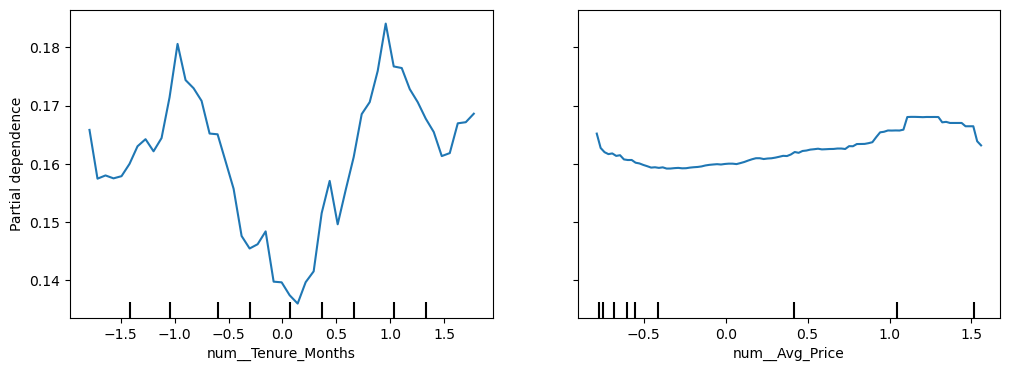

In [12]:
# 7.2 Partial Dependence Plots

# Define features for the partial dependence plot
feature_names = preprocessor.get_feature_names_out()
features = [name for name in feature_names if 'num__Avg_Price' in name or 'num__Tenure_Months' in name]

# Check if X_train_preprocessed is a sparse matrix and convert it to dense
if scipy.sparse.issparse(X_train_preprocessed):
    X_train_preprocessed_dense = X_train_preprocessed.toarray()
else:
    X_train_preprocessed_dense = X_train_preprocessed

# Continue with the partial dependence plot using the dense array
fig, ax = plt.subplots(figsize=(12, 4))
PartialDependenceDisplay.from_estimator(
    tuned_random_forest_model,
    X_train_preprocessed_dense,  # Use the dense version
    features=features,
    ax=ax,
    feature_names=feature_names 
)
plt.show()

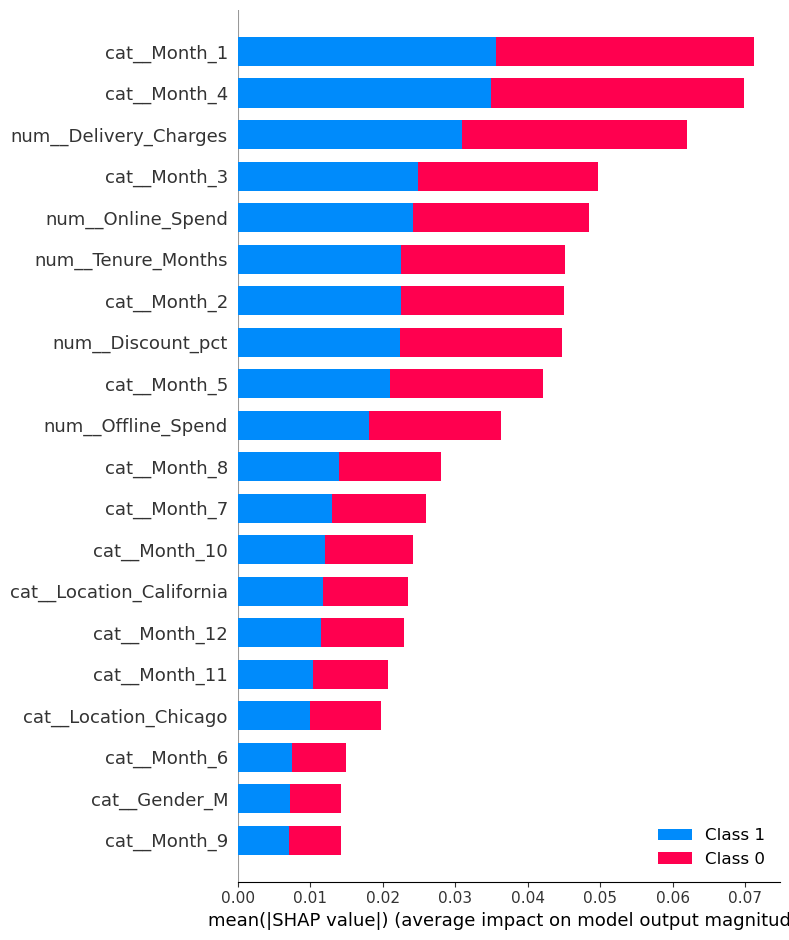

In [13]:
# 7.3 SHAP Values 

# Check if X_test_preprocessed is a sparse matrix and convert it to a dense format
if scipy.sparse.issparse(X_test_preprocessed):
    X_test_preprocessed_dense = X_test_preprocessed.toarray()
else:
    X_test_preprocessed_dense = X_test_preprocessed
    
# Initialize the SHAP Explainer using the model trained on the training dataset
# Use a smaller subset of data for quicker analysis
sample_indices = np.random.choice(X_test_preprocessed_dense.shape[0], 100, replace=False)
X_test_sample = X_test_preprocessed_dense[sample_indices]

# Initialize SHAP explainer on a simpler model or with approximation
explainer = shap.TreeExplainer(tuned_random_forest_model, approximate=True)

# Calculate SHAP values for the sample
shap_values_sample = explainer.shap_values(X_test_sample)

# Plot the summary of SHAP values
shap.summary_plot(shap_values_sample, X_test_sample, feature_names=feature_names)

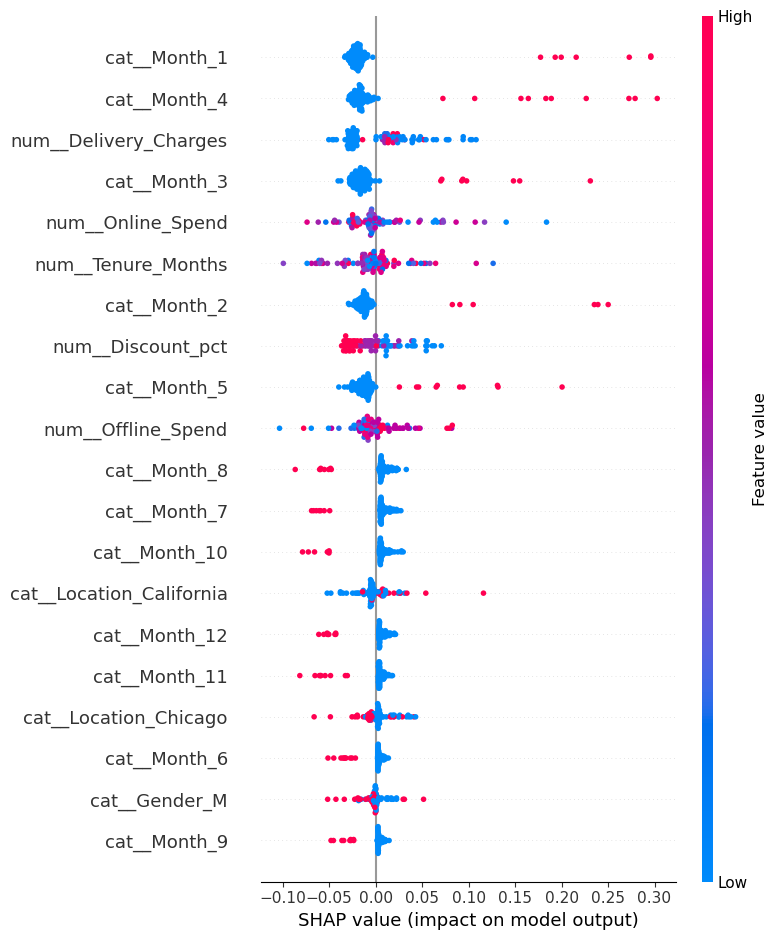

In [14]:
# Select SHAP values for the positive class 
shap_values_positive_class = shap_values_sample[1]

# Plot the summary of SHAP values for the positive class
shap.summary_plot(shap_values_positive_class, X_test_sample, feature_names=feature_names)

# Visualize the SHAP values for the first prediction of the positive class
shap.initjs()  
shap.force_plot(explainer.expected_value[1], shap_values_positive_class[0,:], X_test_sample[0,:], feature_names=feature_names)

In [15]:
# 8) Save the Model for Deployment 
with open('tuned_random_forest_model.pkl', 'wb') as file:
    pickle.dump(tuned_random_forest_model, file)